<a href="https://colab.research.google.com/github/Pramod858/CT-Scan-Covid-19-Diagnosis-Capstone-Project/blob/main/Notebook/CT_Scan_Covid_19_Diagnosis_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About Dataset

We build a public available SARS-CoV-2 CT scan dataset, containing 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1230 CT scans for patients non-infected by SARS-CoV-2, 2482 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil. The aim of this dataset is to encourage the research and development of artificial intelligent methods which are able to identify if a person is infected by SARS-CoV-2 through the analysis of his/her CT scans.


In [1]:
import os
import glob
import random
import shutil
import requests
import zipfile
import pathlib
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
from io import BytesIO

# Import keras modules
import keras
from keras.applications import ResNet101V2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.models import load_model, Model
from keras import models, layers, regularizers
random.seed(42)

from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import RMSprop
# from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path where the images should be saved
image_folder_path = '/content/drive/MyDrive/Capstone_project/Images/Plots'

## 1. Downloading Data

In [4]:
# To download data from the github and where "Data" is the name of the dataset folder.
!git clone --depth 1 --branch=main https://github.com/Pramod858/CT-Scan-Covid-19-Diagnosis-Capstone-Project.git
!mv CT-Scan-Covid-19-Diagnosis-Capstone-Project/Data /content/

Cloning into 'CT-Scan-Covid-19-Diagnosis-Capstone-Project'...
remote: Enumerating objects: 2502, done.
remote: Counting objects: 100% (2502/2502), done.
remote: Compressing objects: 100% (2500/2500), done.
remote: Total 2502 (delta 0), reused 2497 (delta 0), pack-reused 0
Receiving objects: 100% (2502/2502), 231.44 MiB | 27.39 MiB/s, done.
Updating files: 100% (2494/2494), done.


If the above code didn't work uncomment the belove code. Belove is the drive link where the data is.

In [5]:
# # To download data from the drive that is accessible public(anyone)
# !gdown --id "1WBk-9_hCmIFf6bxfCaGBiSO8-tLNBjig"

# # Unzip the downloaded file
# zip_ref = zipfile.ZipFile("/content/Data.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

In [6]:
# # To remove a folder

# folder_path = '/content/covid19_CT'

# shutil.rmtree(folder_path)

### Data Preprocessing

In [7]:
# How many images in each folder?
# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("Data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'Data'.
There are 0 directories and 1229 images in 'Data/NonCovid'.
There are 0 directories and 1252 images in 'Data/Covid'.


In [8]:
# Function to prepare and organize the dataset
def prepare_dataset(original_covid_path, original_non_covid_path, train_covid_path, test_covid_path, train_non_covid_path, test_non_covid_path):
  # Create the destination folders if they don't exist
  os.makedirs(train_covid_path, exist_ok=True)
  os.makedirs(test_covid_path, exist_ok=True)

  os.makedirs(train_non_covid_path, exist_ok=True)
  os.makedirs(test_non_covid_path, exist_ok=True)

  # Load the list of COVID and non-COVID images
  covid_images = os.listdir(original_covid_path)
  non_covid_images = os.listdir(original_non_covid_path)

  # Shuffle the image lists
  random.shuffle(covid_images)
  random.shuffle(non_covid_images)

  # Split sizes for train and test
  covid_train_size = int(0.7 * len(covid_images))
  non_covid_train_size = int(0.7 * len(non_covid_images))

  # Move COVID images to the train folder
  for image in covid_images[:covid_train_size]:
      shutil.copyfile(os.path.join(original_covid_path, image), os.path.join(train_covid_path, image))

  # Move COVID images to the test folder
  for image in covid_images[covid_train_size:]:
      shutil.copyfile(os.path.join(original_covid_path, image), os.path.join(test_covid_path, image))

  # Move non-COVID images to the train folder
  for image in non_covid_images[:non_covid_train_size]:
      shutil.copyfile(os.path.join(original_non_covid_path, image), os.path.join(train_non_covid_path, image))

  # Move non-COVID images to the test folder
  for image in non_covid_images[non_covid_train_size:]:
      shutil.copyfile(os.path.join(original_non_covid_path, image), os.path.join(test_non_covid_path, image))


The dataset is divided in such a way that 70% of the images are allocated for training, while the remaining 30% are designated for testing. This split ensures that a substantial portion of the data is utilized for model training, allowing the model to learn from a diverse range of samples, while the test data serves as an independent evaluation set to assess the model's performance.

In [9]:
# Set the paths for the original dataset and the destination folders
original_covid_path = '/content/Data/Covid'
original_non_covid_path = '/content/Data/NonCovid'

train_covid_path = '/content/covid19_CT/train/COVID'
test_covid_path = '/content/covid19_CT/test/COVID'

train_non_covid_path = '/content/covid19_CT/train/Non-COVID'
test_non_covid_path = '/content/covid19_CT/test/Non-COVID'

# Call the Function to prepare and organize the dataset.
prepare_dataset(original_covid_path, original_non_covid_path, train_covid_path, test_covid_path, train_non_covid_path, test_non_covid_path)

In [10]:
train_covid = os.listdir(train_covid_path)
train_non_covid = os.listdir(train_non_covid_path)

test_covid = os.listdir(test_covid_path)
test_non_covid = os.listdir(test_non_covid_path)

print("train size : ",len(train_covid)+len(train_non_covid))
print("test size : ",len(test_covid)+len(test_non_covid))

train size :  1736
test size :  745


In [11]:
# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/covid19_CT"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/covid19_CT'.
There are 2 directories and 0 images in '/content/covid19_CT/train'.
There are 0 directories and 860 images in '/content/covid19_CT/train/Non-COVID'.
There are 0 directories and 876 images in '/content/covid19_CT/train/COVID'.
There are 2 directories and 0 images in '/content/covid19_CT/test'.
There are 0 directories and 369 images in '/content/covid19_CT/test/Non-COVID'.
There are 0 directories and 376 images in '/content/covid19_CT/test/COVID'.


In [12]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
data_dir = pathlib.Path("/content/covid19_CT/train") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['COVID' 'Non-COVID']


In [13]:
# View an image

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img


Image shape: (243, 385, 3)


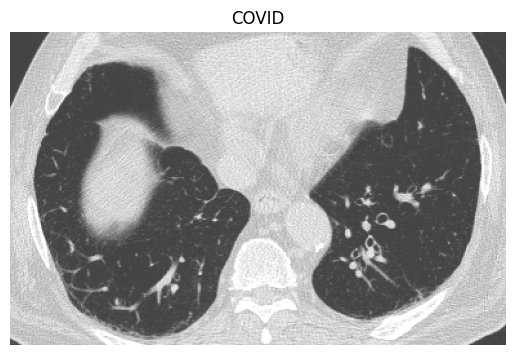

In [14]:
# View a random image from the training dataset
img = view_random_image(target_dir="/content/covid19_CT/train/",
                        target_class="COVID")

In [15]:
# Define training and test directory paths
train_dir = "/content/covid19_CT/train/"
test_dir = "/content/covid19_CT/test/"

## 3. Setting the image size

Setting the image size to H=224 and W=224 standardizes all images to the same dimensions, ensuring compatibility with model requirements and efficient batch processing. This prevents bias and simplifies dataset management.

In [16]:
# Setting the size of the image

H=224
W=224

## 3. Data Augmentation

An image data pipeline is set up using Keras' `ImageDataGenerator` for both training and testing datasets.
* For the training data:

1. The images are rescaled to a range between 0 and 1 using `rescale=1/255`.
2. Augmentation techniques are applied to diversify the training data, including random rotation, horizontal and vertical shifts, shear transformation, zooming, and horizontal flipping.
3. The `fill_mode` ensures that any areas outside the original image boundaries are filled with the nearest pixel value.
4. The data is loaded from the `train_dir` directory and resized to the specified `target_size`.
5. Batch size of 32 images is used for training.
6. Images are classified into categories (class_mode='categorical').
7. Shuffle is set to True, so the training data is shuffled before each epoch.

* For the testing data:

1. Similar to training data, the images are rescaled using `rescale=1/255`.
2. No augmentation is applied to the testing data.
3. The data is loaded from the `test_dir` directory and resized.
4. Batch size of 32 images is used for testing.
5. Images are classified into categories (class_mode='categorical').
6. Shuffle is set to False, as shuffling is not needed for testing.

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,        # Random rotation up to 20 degrees
    width_shift_range=0.1,    # Random horizontal shift of 10% of the image width
    height_shift_range=0.1,   # Random vertical shift of 10% of the image height
    shear_range=0.2,          # Shear transformation with maximum angle of 20 degrees
    zoom_range=0.2,           # Random zoom of up to 20%
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest',      # Fill points outside the boundaries with the nearest pixel
    dtype='float64')

#on test, we do not augment, merely preprocess
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                                            dtype='float64')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (W,H),
    batch_size = 32,
    class_mode='categorical',
    shuffle=True # Shuffle the data during training
    )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (W,H),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle=False # No need to shuffle the test data
    )


Found 1736 images belonging to 2 classes.
Found 745 images belonging to 2 classes.


Augmented image label: COVID


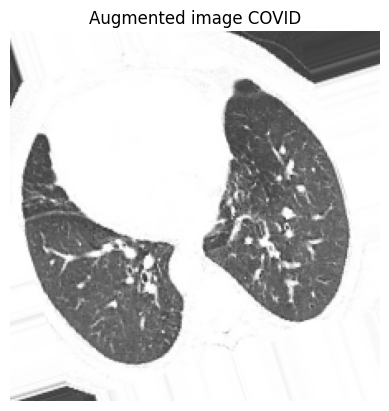

In [18]:
# Get data batch samples
augmented_images, augmented_labels = train_generator.next()  # Note: labels aren't augmented, they stay the same
random_number = random.randint(0, 32)  # we're making batches of size 32, so we'll get a random instance

# Get the class names from the generator
class_names = list(train_generator.class_indices.keys())

# Get the label index of the augmented image
label_index = np.argmax(augmented_labels[random_number])

# Get the class name corresponding to the label index
class_name = class_names[label_index]

# Print the augmented image and its corresponding label
print(f"Augmented image label: {class_name}")
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image {class_name}")
plt.axis(False)
plt.show()


## 4. ResNet Model

ResNet-101v2 is an upgraded version of the ResNet-101 architecture, which is a deep convolutional neural network (CNN). It incorporates improvements to the original ResNet model by optimizing the residual block structure, resulting in better training convergence and accuracy. Like its predecessor, ResNet-101v2 is trained on the ImageNet dataset, a large collection of labeled images, to learn features that can be transferred to various computer vision tasks. It utilizes skip connections and residual blocks to enable training of very deep networks, mitigating the vanishing gradient problem and facilitating the training of deeper architectures.

In [19]:
# Downloading the ResNet101V2 Model as base_model
base_model = ResNet101V2(
        include_top = False,
        weights = "imagenet")

171317808/171317808 [==============================] - 1s 0us/step


### No Fine Tuning

#### Define Model

1. **Extract Features**: The output from the base pre-trained model is taken and processed using Global Average Pooling (GAP). This step converts the spatial features of the original image into a fixed-length vector of features.

2. **Fully Connected Layer**: A densely connected layer is introduced, containing 1024 units and ReLU activation. Additionally, L2 regularization with a strength of 0.01 is applied to the weights of this layer, aiding in mitigating overfitting.

3. **Batch Normalization**: Batch Normalization is applied to normalize the activations of the previous layer. This helps in stabilizing training and improving convergence.

4. **Dropout**: To further counter overfitting, a Dropout layer with a dropout rate of 0.5 is incorporated. Dropout randomly deactivates a fraction of neurons during each training step.

5. **Final Classification Layer**: The last fully connected layer consists of 2 units with sigmoid activation. This layer produces the final classification output for binary classification tasks.

6. **Combining Layers**: The complete model is formed by combining the input layer of the base model and the newly added custom layers. This allows the model to accept the same input as the base model and generate predictions through the customized architecture.

In [20]:
# No fine tuning

# Extract features from the base model's output using Global Average Pooling (GAP)
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with 1024 units and ReLU activation
# Apply L2 regularization with a strength of 0.01 to prevent overfitting
x = Dense(1024, activation = 'relu', kernel_regularizer = regularizers.l2(0.01),)(x)

# Apply Batch Normalization to stabilize training and improve convergence
x = BatchNormalization()(x)

# Apply Dropout with a rate of 0.5 to prevent overfitting during training
x = Dropout(0.5)(x)

# Final fully connected layer with 2 units and sigmoid activation for binary classification
outputs = Dense(2, activation='sigmoid')(x)

# Create the final model by combining the base model's input and the custom layers
model_initial = Model(inputs=base_model.input, outputs=outputs)

In [21]:
# Display a summary of the model's architecture
model_initial.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [22]:
# Freeze the layers of the base model to prevent their weights from being updated during training
for layer in base_model.layers:
        layer.trainable = False

By setting each layer's 'trainable' attribute to False, we ensure that the weights of the base model's layers are not updated during subsequent training. This helps preserve the knowledge learned from pre-training on the ImageNet dataset and allows us to focus on fine-tuning the added custom layers for our specific task.

In [23]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_initial.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

* **ModelCheckpoint**: This callback saves the model's weights during training. It monitors a specified metric (in this case, validation accuracy) and saves the model's weights to the given file path whenever the monitored metric improves. By setting `save_best_only=True`, it ensures that only the weights of the best-performing model are saved.

* **EarlyStopping**: This callback monitors a specified metric (in this case, validation loss). If the validation loss doesn't improve for a certain number of epochs (defined by `patience`), training is stopped early. This helps prevent overfitting by stopping training when the model's performance on the validation set stops improving.

Both of these callbacks are tools to enhance the training process and prevent common issues like overfitting.

In [24]:
# Set file path to save model
file_path = '/content/drive/MyDrive/Capstone_project/Saved_Models/initial_model.h5'

# Define a ModelCheckpoint callback to save the best model during training
cp = ModelCheckpoint(
    filepath=file_path,  # Filepath to save the model
    verbose=1,  # Verbosity level for the callback output
    monitor='val_accuracy',  # Monitor validation accuracy to decide when to save
    mode='max',  # Choose 'max' since we want to maximize the validation accuracy
    save_best_only=True  # Save only the best model based on the monitored metric
)

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss to decide when to stop
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    mode='min',  # Choose 'min' since we want to minimize the validation loss
    verbose=1  # Verbosity level for the callback output
)

* Since we're working on a binary classification problem (Covid vs. Non-Covid), the `loss` function we're using is `'binary_crossentropy'`, if it was mult-iclass, we might use something like `'categorical_crossentropy'`.

* `RMSprop` is an optimization algorithm commonly used for binary classification. It adapts learning rates for each parameter based on squared gradients, helping stabilize training, mitigate exploding gradients, and accelerate convergence, and our evaluation metric is accuracy.
* We are setting the learning rate for `RMSprop` is `0.0001` for the initial model(No fine tuning)

In [25]:
# Compile the model with optimizer, loss, and evaluation metrics
model_initial.compile(
    optimizer = RMSprop(learning_rate=0.0001),  # Optimizer with a specific learning rate
    loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
    metrics=['accuracy']  # Evaluation metric: accuracy
)

# Train the model using the training generator and validate using the test generator
# Include the defined callbacks: ModelCheckpoint and EarlyStopping
history_initial = model_initial.fit(
    train_generator,  # Training data generator
    epochs=100,  # Number of training epochs
    validation_data=test_generator,  # Validation data generator
    callbacks=[cp, early_stopping_callback],  # Callbacks to enhance training and monitoring
    verbose=1  # Verbosity level for training progress output
)

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 12.8017 - accuracy: 0.7241
Epoch 1: val_accuracy improved from -inf to 0.80537, saving model to /content/drive/MyDrive/Capstone_project/Saved_Models/initial_model.h5
55/55 [==============================] - 58s 745ms/step - loss: 12.8017 - accuracy: 0.7241 - val_loss: 11.4630 - val_accuracy: 0.8054
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 10.5012 - accuracy: 0.8116
Epoch 2: val_accuracy improved from 0.80537 to 0.84966, saving model to /content/drive/MyDrive/Capstone_project/Saved_Models/initial_model.h5
55/55 [==============================] - 37s 674ms/step - loss: 10.5012 - accuracy: 0.8116 - val_loss: 9.4531 - val_accuracy: 0.8497
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 8.6923 - accuracy: 0.8237
Epoch 3: val_accuracy did not improve from 0.84966
55/55 [==============================] - 34s 623ms/step - loss: 8.6923 - accuracy: 0.8237 - val_loss: 7.8294 - val

### Fine Tuning

In **fine-tuning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

We chose to use fine-tuning instead of the previous approach because it significantly improved the accuracy of the model. Fine-tuning allowed us to adjust the model's pre-trained layers to better fit the specific features of the new dataset. This adaptation was necessary to achieve higher accuracy, as the initial approach didn't provide satisfactory results. Fine-tuning demonstrated its effectiveness by producing improved performance on the task.

We used batch size is `4` because,

Certainly, by setting a batch size of 4 during fine-tuning, you are processing a smaller number of images in each training iteration. This can lead to better results and improved accuracy because:

1. **Reduced Overfitting**: Smaller batch sizes can introduce more noise into the learning process, acting as a form of regularization. This can prevent the model from overfitting to the training data and improve its generalization to unseen data.

2. **Better Convergence**: Smaller batch sizes often lead to quicker convergence during training. The model adapts faster to the data, as each batch provides a more frequent update to the model's weights based on the current training data.

However, it's worth noting that using a smaller batch size may also increase training time due to the more frequent weight updates. It's a trade-off between faster convergence and potentially increased computation time.

In [26]:
# Create a training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,            # Directory containing training images
    target_size=(W, H),   # Resize images to specified dimensions
    batch_size=4,         # Number of images per batch
    class_mode='categorical',  # Mode for class labels (categorical for one-hot encoded labels)
    shuffle=True           # No need to shuffle
)

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,             # Directory containing test images
    target_size=(W, H),   # Resize images to specified dimensions
    batch_size=32,       # Number of images per batch
    class_mode='categorical',  # Mode for class labels (categorical for one-hot encoded labels)
    shuffle=False          # Do not shuffle the test data to maintain order
)


Found 1736 images belonging to 2 classes.
Found 745 images belonging to 2 classes.


In [27]:
# Create a new instance for the fine-tuning model
model_fine_tuning = load_model("/content/drive/MyDrive/Capstone_project/Saved_Models/initial_model.h5")

We are loading the saved model of the `model_initial` to perform the `Fine-Tuning`.

In [28]:
# Allow all layers in the base model to be trainable
model_fine_tuning.trainable = True

# Refreeze all layers except for the last 15 layers for fine-tuning
for layer in model_fine_tuning.layers[:-150]:
    layer.trainable = False

We enabled training for all base model layers in `model_fine_tuning`, and then I unfroze only the last 150 layers for more focused adjustments by marking them as trainable, while keeping others frozen to retain pre-trained knowledge. This strategy helps balance adaptation and prevents overfitting.

In [29]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_fine_tuning.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [30]:
# Set file path to save model
file_path = '/content/drive/MyDrive/Capstone_project/Saved_Models/best_model.h5'

# Define a ModelCheckpoint callback to save the best model during fine-tuning
cp2 = ModelCheckpoint(
    filepath=file_path,  # Filepath to save the model
    verbose=1,  # Verbosity level for the callback output
    monitor='val_accuracy',  # Monitor validation accuracy to decide when to save
    mode='max',  # Choose 'max' since we want to maximize the validation accuracy
    save_best_only=True  # Save only the best model based on the monitored metric
)

# Define the EarlyStopping callback for fine-tuning
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss to decide when to stop
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    mode='min',  # Choose 'min' since we want to minimize the validation loss
    verbose=1  # Verbosity level for the callback output
)

We compiled the model similarly to the initial model, but with a lower learning rate of `1e-5` in the `RMSprop` optimizer. This modification helps the model to make smaller adjustments to the pre-trained weights during training, which is beneficial for refining the model's performance on our specific task. The rest of the training process remains similar to the initial model, including callbacks for saving the best model and early stopping.

In [31]:
# Compile the model for fine-tuning with a different learning rate
model_fine_tuning.compile(
    optimizer=RMSprop(learning_rate=1e-5),  # Optimizer with a specific learning rate
    loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
    metrics=['accuracy']  # Evaluation metric: accuracy
)

# Fine-tune the model using the training generator and validate using the test generator
history_fine_tuning = model_fine_tuning.fit(
    train_generator,  # Training data generator
    epochs=100,  # Number of fine-tuning epochs
    validation_data=test_generator,  # Validation data generator
    # initial_epoch=hist.epoch[-1],  # Uncomment this line if continuing training from previous history
    callbacks=[cp2, early_stopping_callback],  # Callbacks to enhance training and monitoring
    verbose=1  # Verbosity level for training progress output
)

Epoch 1/100
434/434 [==============================] - ETA: 0s - loss: 0.9071 - accuracy: 0.7327
Epoch 1: val_accuracy improved from -inf to 0.85369, saving model to /content/drive/MyDrive/Capstone_project/Saved_Models/best_model.h5
434/434 [==============================] - 71s 129ms/step - loss: 0.9071 - accuracy: 0.7327 - val_loss: 0.6077 - val_accuracy: 0.8537
Epoch 2/100
434/434 [==============================] - ETA: 0s - loss: 0.7373 - accuracy: 0.7863
Epoch 2: val_accuracy improved from 0.85369 to 0.87248, saving model to /content/drive/MyDrive/Capstone_project/Saved_Models/best_model.h5
434/434 [==============================] - 52s 119ms/step - loss: 0.7373 - accuracy: 0.7863 - val_loss: 0.5476 - val_accuracy: 0.8725
Epoch 3/100
434/434 [==============================] - ETA: 0s - loss: 0.6580 - accuracy: 0.8122
Epoch 3: val_accuracy improved from 0.87248 to 0.89128, saving model to /content/drive/MyDrive/Capstone_project/Saved_Models/best_model.h5
434/434 [==================

## 5. Doing Prediction and Multiple Performance Metrics

In [32]:
def plot_loss_curves(history, model_name, image_path):
    """
    Plots loss and accuracy curves side by side for training and validation metrics.
    Saves the plot as an image in the specified image_path with the provided model_name.
    Displays the plot as well.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

    # Plot loss curves on the first subplot
    ax1.plot(epochs, loss, label='training_loss')
    ax1.plot(epochs, val_loss, label='val_loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    # Plot accuracy curves on the second subplot
    ax2.plot(epochs, accuracy, label='training_accuracy')
    ax2.plot(epochs, val_accuracy, label='val_accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.legend()

    # Adjust layout
    plt.tight_layout()

    # Save the combined plot as an image
    plt.savefig(f'{image_path}/{model_name}_loss_accuracy_plot.png')

    # Display the plot
    plt.show()

    # Close the plot to start a new one
    plt.close()

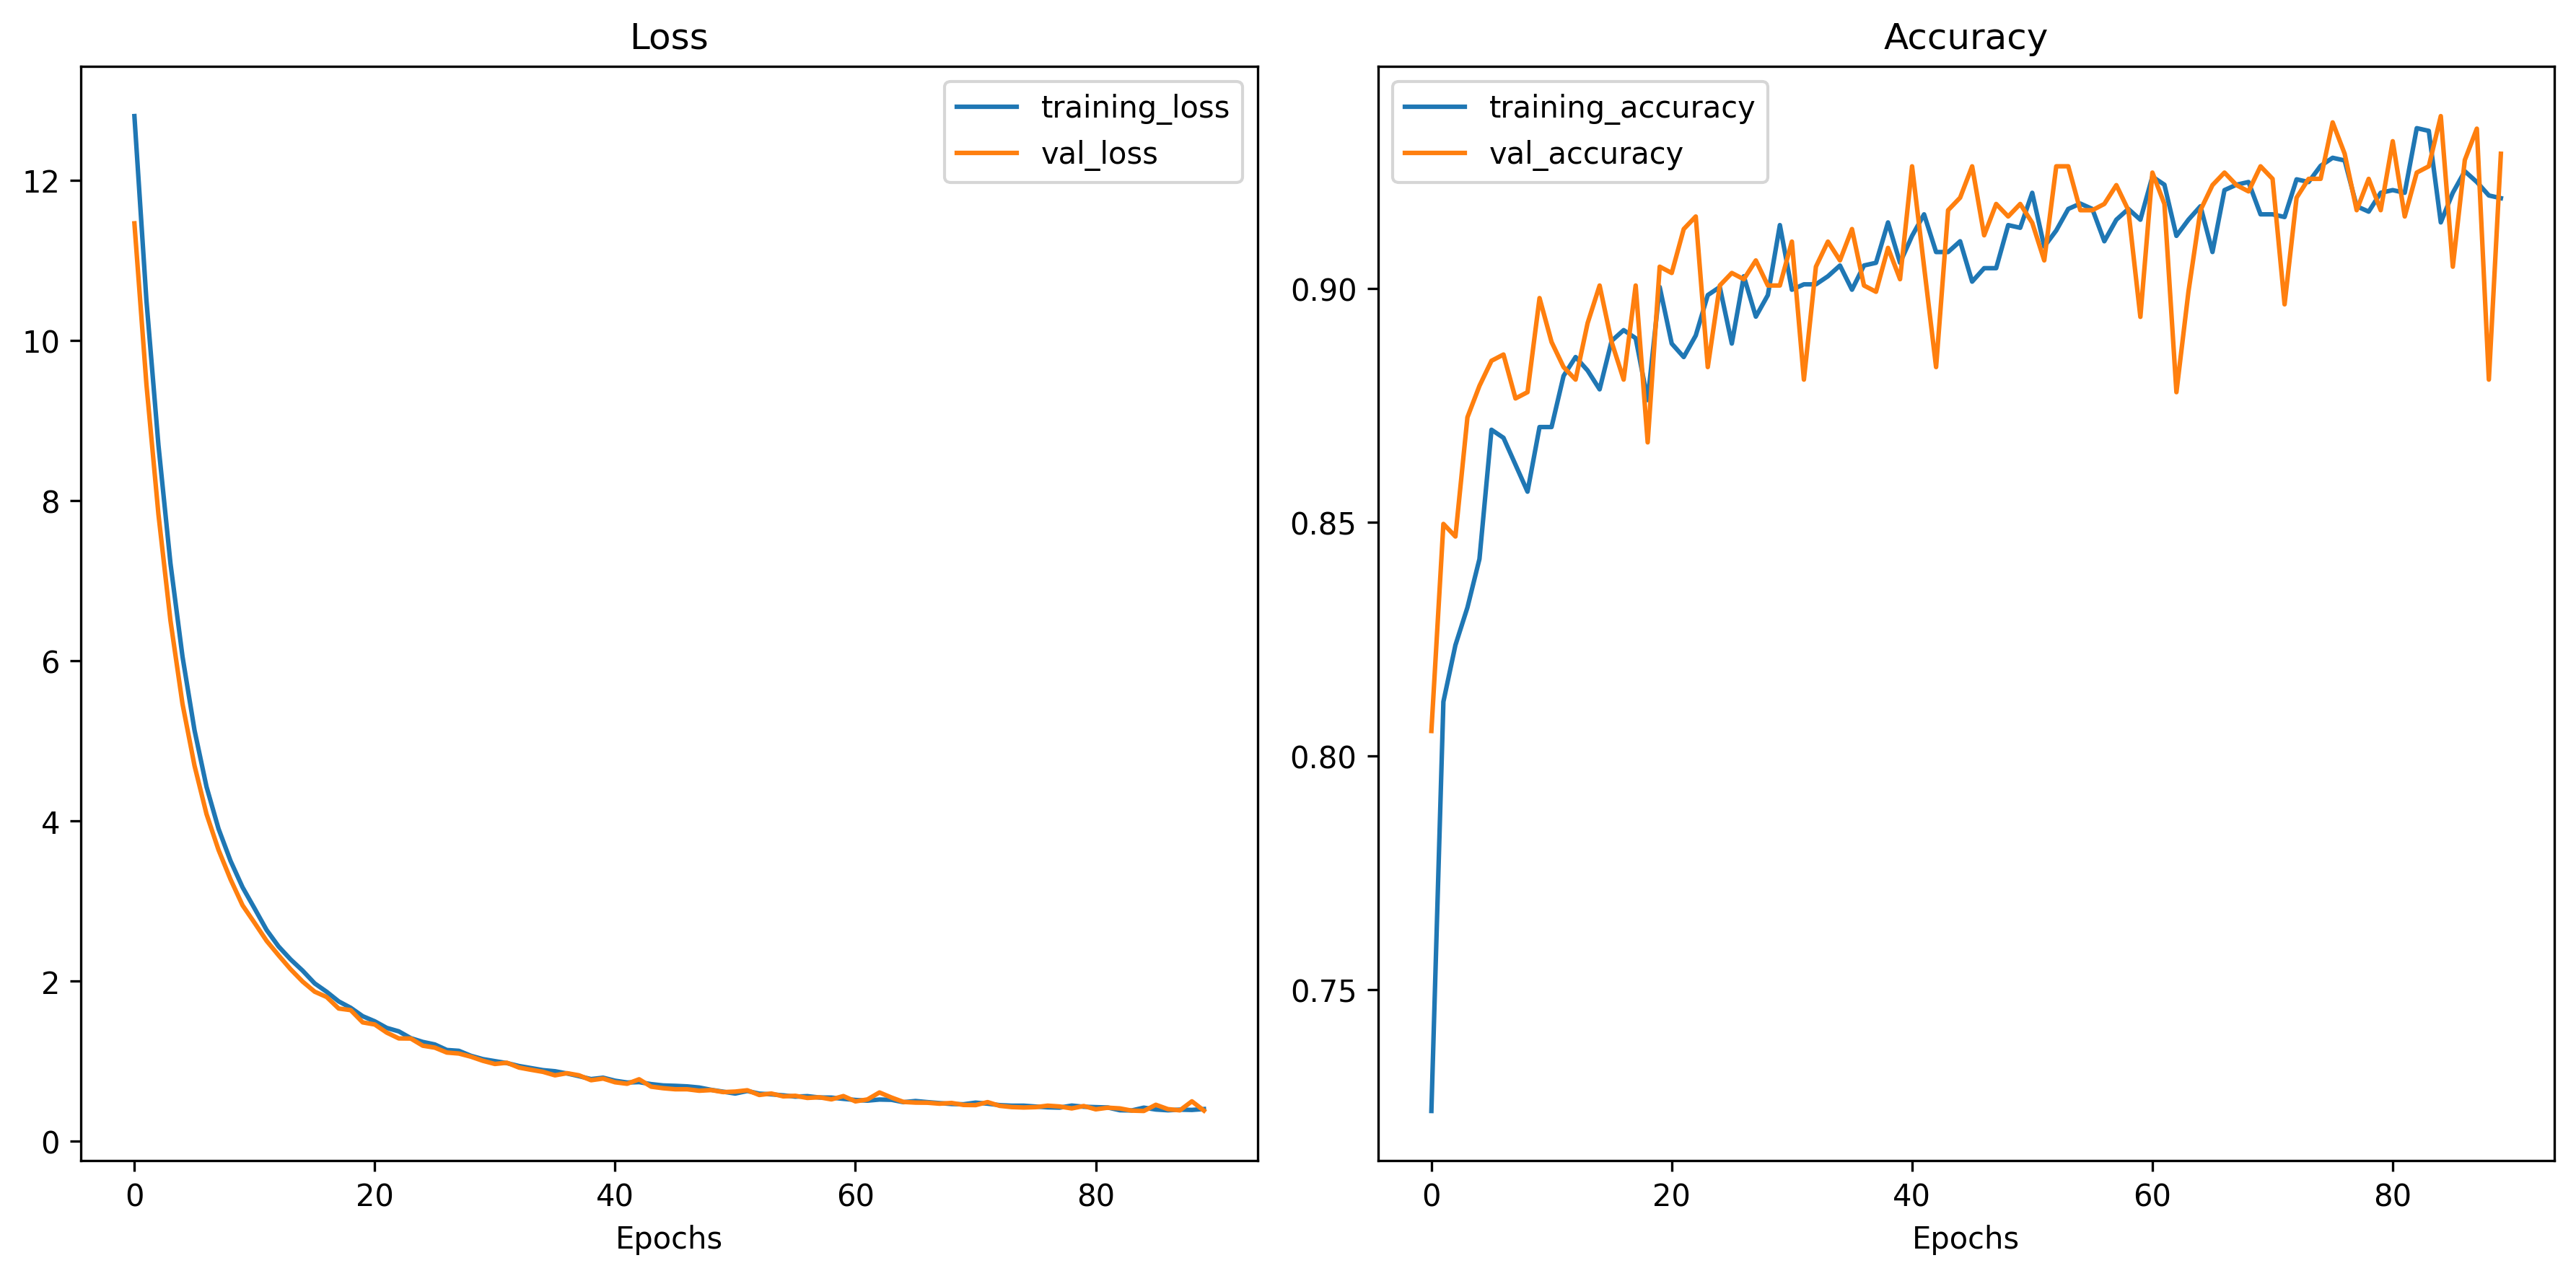

In [33]:
# Call the function to plot and save the curves for the initial model
plot_loss_curves(history_initial, 'initial_model', image_folder_path)

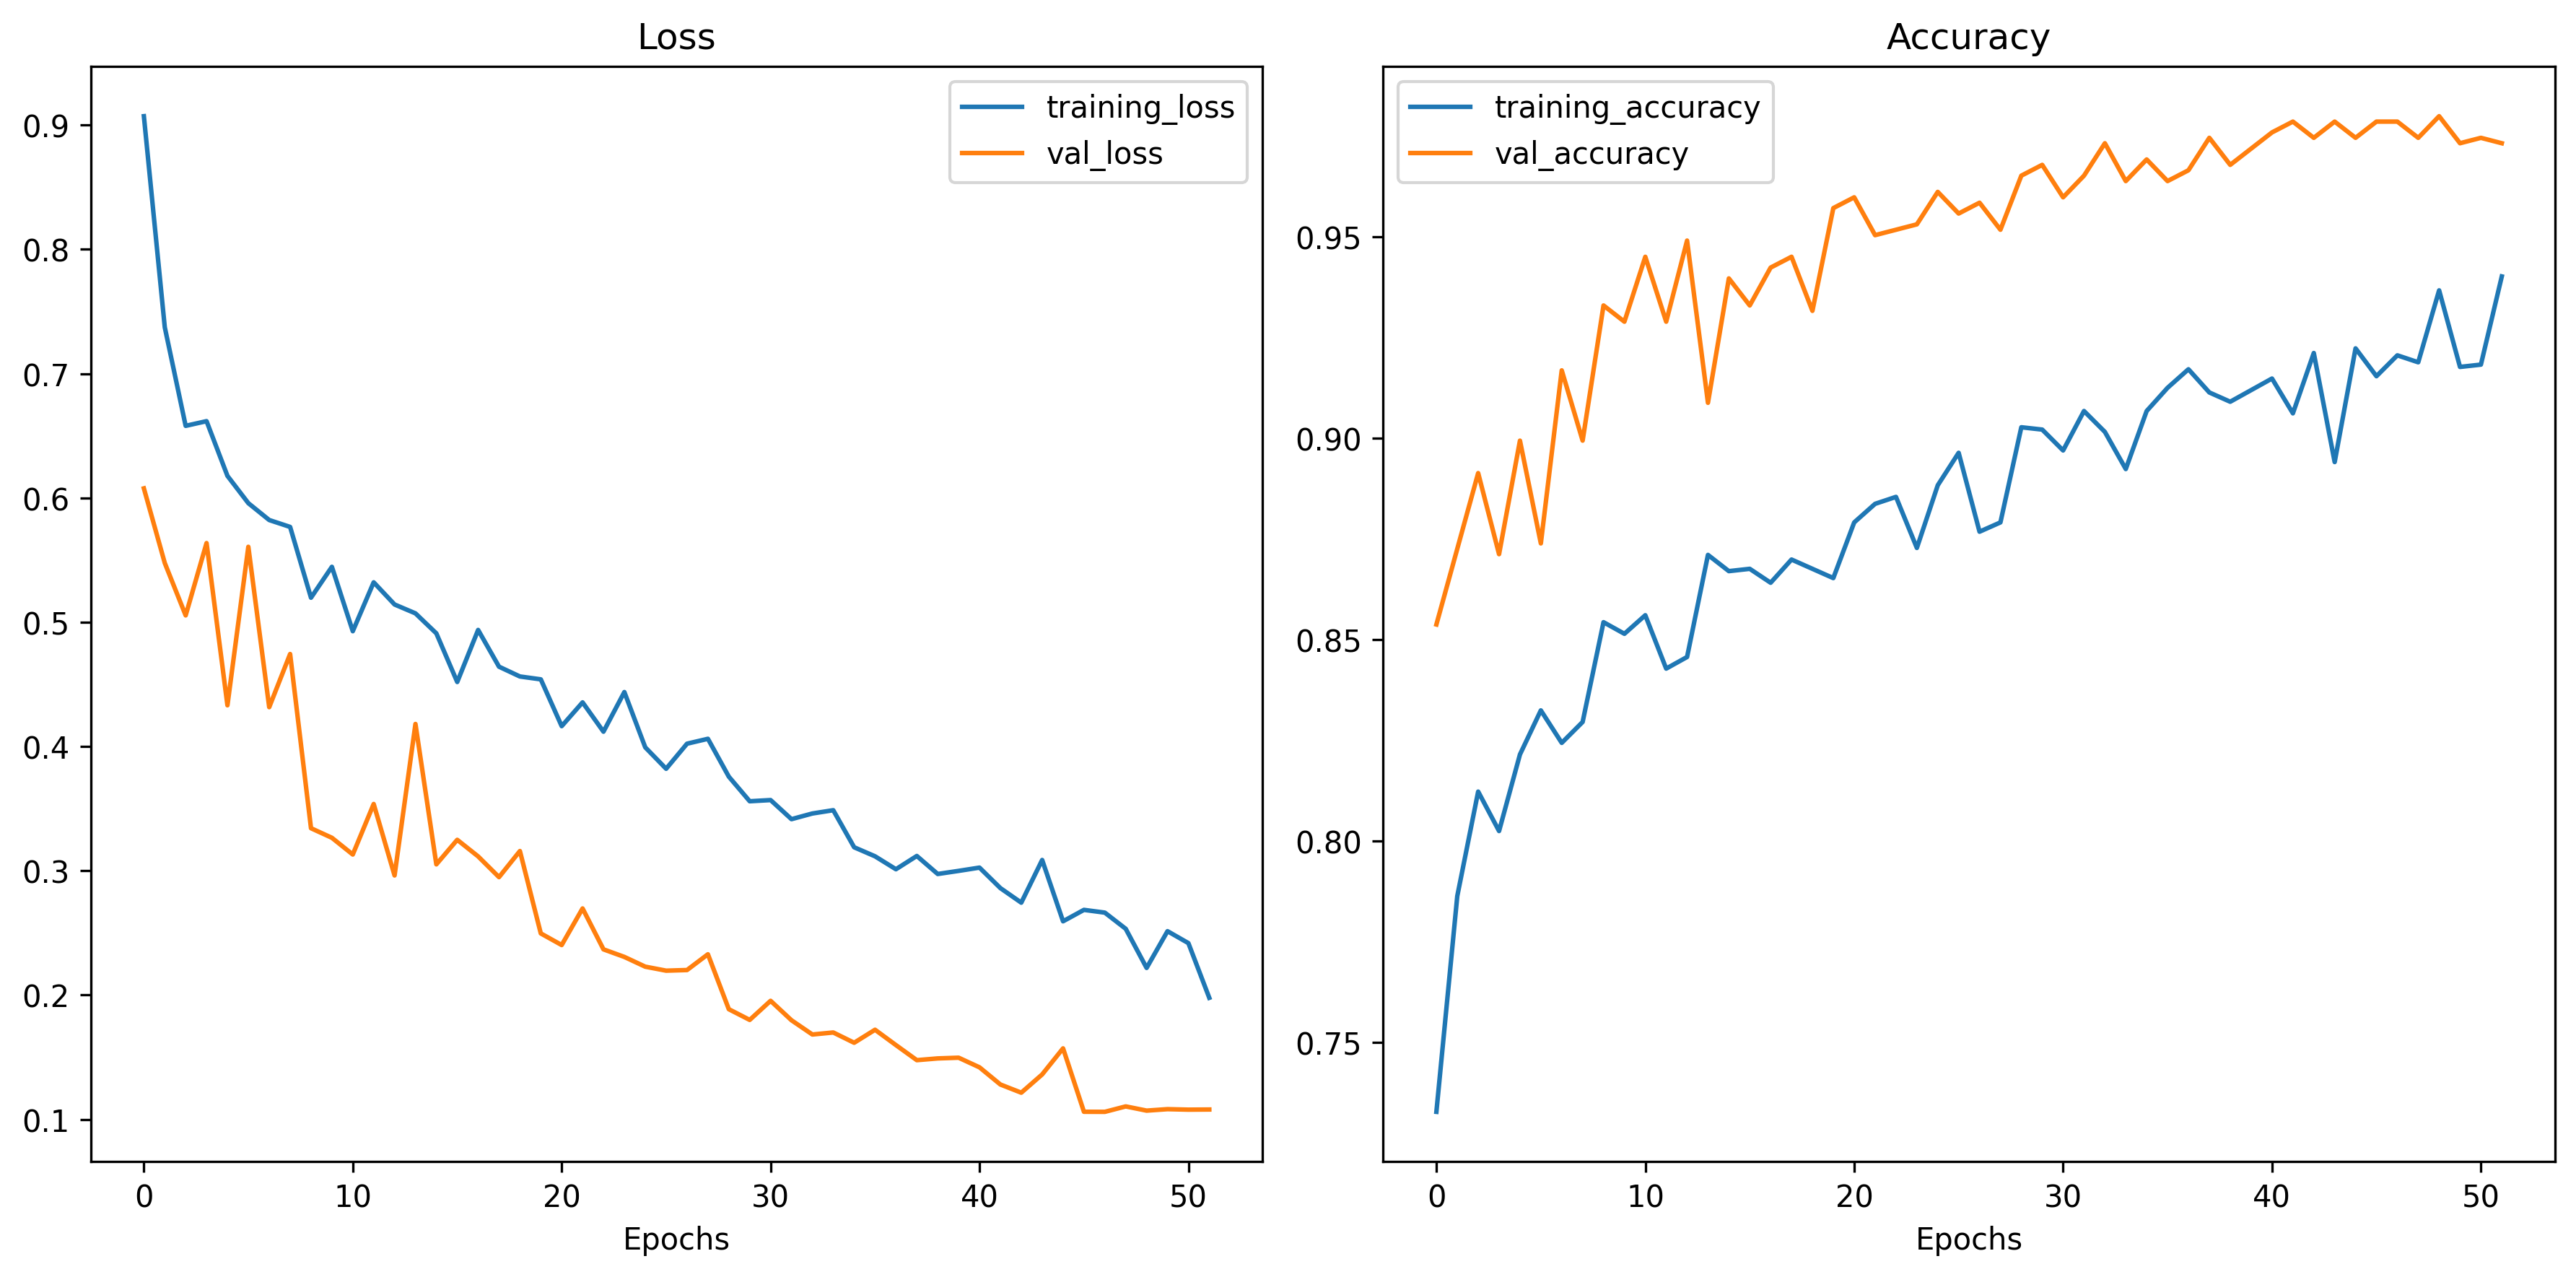

In [34]:
# Call the function to plot and save the curves for the fine-tuned model
plot_loss_curves(history_fine_tuning, 'fine_tuned_model', image_folder_path)

As we can see in the above two plots `model_initial` and `model_fine_tuning`, `model_fine_tuning` reached best accuracy and better loss than the `model_initial`.

In [35]:
# Evaluate on the test data for model_initial
model_initial_eval = model_initial.evaluate(test_generator)
model_initial_eval

24/24 [==============================] - 5s 188ms/step - loss: 0.3846 - accuracy: 0.9289


[0.38462990522384644, 0.9288590550422668]

In [36]:
# Evaluate on the test data for model_fine_tuning
model_fine_tune_eval = model_fine_tuning.evaluate(test_generator)
model_fine_tune_eval

24/24 [==============================] - 5s 219ms/step - loss: 0.1079 - accuracy: 0.9732


[0.10789495706558228, 0.9731543660163879]

As we can see in the evaluation the `Fine Tuned Model` gave better accuracy(i.e.`>95%`) than `Non-Fine Tuned Model` and also loss of the `Fine Tuned Model` improved well.

In [37]:
# Finding the labels of the test data
true_labels = test_generator.classes
true_labels[:200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

### Prediction

In [38]:
# Make predictions using your trained initial model
predicted_probabilities_initial = model_initial.predict(test_generator)
predicted_classes_initial = np.argmax(predicted_probabilities_initial, axis=1)
predicted_classes_initial[:200]

24/24 [==============================] - 6s 183ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [39]:
# Make predictions using your trained initial model
predicted_probabilities_fine_tuned = model_fine_tuning.predict(test_generator)
predicted_classes_fine_tuned = np.argmax(predicted_probabilities_fine_tuned, axis=1)
predicted_classes_fine_tuned[:200]

24/24 [==============================] - 7s 244ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

### Multiple Performance Metrics

#### Confusion Matrix

In [50]:
def plot_confusion_matrix(model, data_generator, class_names, model_name, image_path):
    # Get true labels
    true_labels = data_generator.classes

    # Make predictions using the model
    predicted_probabilities = model.predict(data_generator)
    predicted_classes = np.argmax(predicted_probabilities, axis=1)

    # Create a confusion matrix
    cm = confusion_matrix(true_labels, predicted_classes)

    # Plot the confusion matrix
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(f'{image_path}/{model_name}_confusion_matrix.png')  # Save the confusion matrix plot as an image
    plt.show()

24/24 [==============================] - 5s 190ms/step


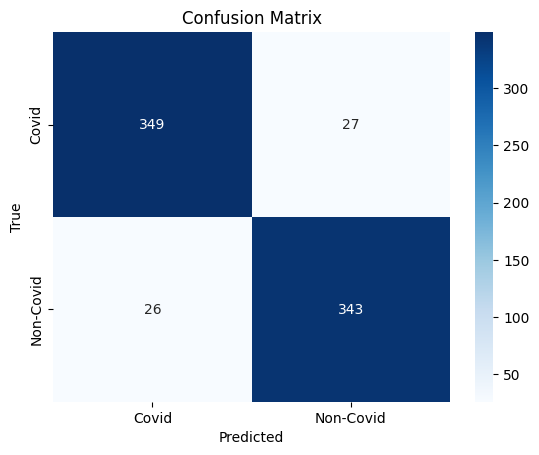

In [51]:
# Call the function to plot and save the confusion matrix for the initial model
plot_confusion_matrix(model_initial, test_generator, class_names, 'initial_model', image_folder_path)

24/24 [==============================] - 6s 246ms/step


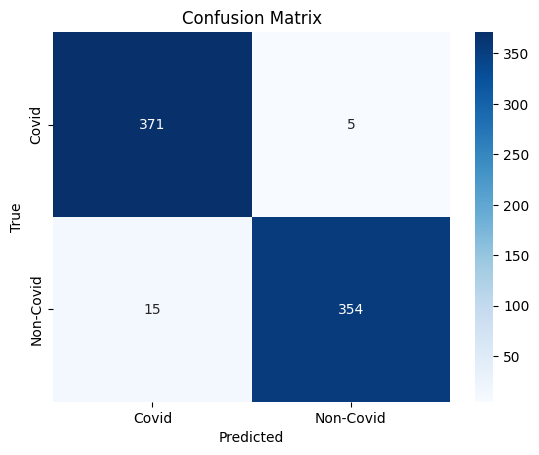

In [52]:
# Call the function to plot and save the confusion matrix for the fine-tuned model
plot_confusion_matrix(model_fine_tuning, test_generator, class_names, 'fine_tuned_model', image_folder_path)

#### Metrices(Accuracy, Precision, Recall, F1, Auc)

In [43]:
def multiple_metrics(true_labels, predicted_classes, predicted_probabilities=None):
    # Calculate various performance metrics
    accuracy = accuracy_score(true_labels, predicted_classes)
    precision = precision_score(true_labels, predicted_classes)
    recall = recall_score(true_labels, predicted_classes)
    f1 = f1_score(true_labels, predicted_classes)

    # Calculate ROC AUC score if predicted_probabilities is provided
    roc_auc = None
    if predicted_probabilities is not None:
        roc_auc = roc_auc_score(true_labels, predicted_probabilities[:, 1])  # Assuming you're calculating for the positive class

    # Create a dictionary to hold the metrics
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC Score': roc_auc
    }

    return metrics

In [44]:
# Calculate metrics for the initial model
initial_metrics = multiple_metrics(true_labels, predicted_classes_initial,predicted_probabilities_initial)

# Calculate metrics for the fine-tuned model
fine_tuned_metrics = multiple_metrics(true_labels, predicted_classes_fine_tuned,predicted_probabilities_fine_tuned)

In [45]:
# Create a DataFrame to compare the metrics
metrics_df = pd.DataFrame([initial_metrics, fine_tuned_metrics], index=['Initial Model', 'Fine-Tuned Model'])

# Print the DataFrame
metrics_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Initial Model,0.928859,0.927027,0.929539,0.928281,0.976287
Fine-Tuned Model,0.973154,0.986072,0.959350,0.972527,0.998032


As we can see above `Fine-Tuned Model` gavebest results than `Initial Model`(No fine tuning)

### Predicting the unkown data

You can use local data or external data to make prediction using trained model `model_fine_tuning`

We used data to test that is not used to to train the model then we get this belove results, and you can see the data <a href="https://github.com/Pramod858/CT-Scan-Covid-19-Diagnosis-Capstone-Project/tree/main/Images/test%20data">here</a>

1/1 [==============================] - 0s 137ms/step
Predicted class: Non-Covid
Confidence: 1.0000


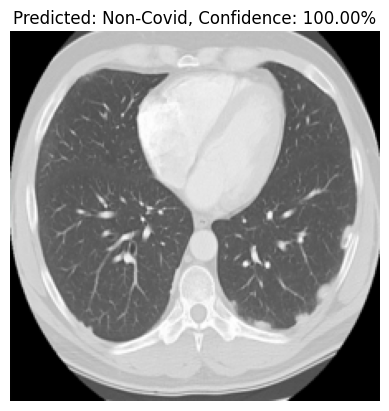

In [53]:
# Path to the external/local image you want to predict
external_image_loc = 'https://github.com/Pramod858/CT-Scan-Covid-19-Diagnosis-Capstone-Project/blob/main/Images/test%20data/NonCovid/1330.png?raw=true'

# Download the image using requests
# If want to use local data comment these below two lines
response = requests.get(external_image_loc)
img = Image.open(BytesIO(response.content))

# Load and preprocess the external image
img = img.resize((224, 224))  # Resize the image to the target size
img_array = image.img_to_array(img)  # Convert the image to a numpy array
img_array = img_array[:, :, :3]  # Keep only the first 3 color channels (RGB)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
preprocessed_img = img_array / 255.0  # Normalize pixel values to [0, 1]

# Make prediction using the model
predicted_probabilities = model_fine_tuning.predict(preprocessed_img)  # Get predicted class probabilities
predicted_class = np.argmax(predicted_probabilities)  # Get the index of the predicted class

# Define class names
class_names = ['Covid', 'Non-Covid']

# Interpret the prediction
predicted_label = class_names[predicted_class]  # Get the corresponding class label
confidence = predicted_probabilities[0][predicted_class]  # Get the confidence of the prediction

# Print the prediction result
print(f"Predicted class: {predicted_label}")
print(f"Confidence: {confidence:.4f}")

# Display the image
plt.imshow(img)  # Display the loaded image
plt.title(f"Predicted: {predicted_label}, Confidence: {confidence:.2%}")
plt.axis('off')  # Turn off axis
plt.show()  # Show the plot